In [1]:
# import sys
# sys.path.append("../")

########################
## tesing simulations ##

# from sim_handling import Simulation
# from sim_handling_new import SimulationNew
# import diffusion as df
# import diffusionstuff7 as ds
########################

######################
## testing 0d stuff ##

from diffusion import getsigmastep ## this was never changed, matches diffusionstuff7's version exactly
from diffusion import f0d as f0dNew
from diffusionstuff7 import f0d as f0dOld
######################


######################
## testing 1d stuff ##

# from diffusion import getsigmastep ## this was never changed, matches diffusionstuff7's version exactly
# from diffusion import f1d as f1dNew
# from diffusionstuff7 import f1d as f1dOld
######################


######################
## testing 2d stuff ##

# from diffusion import getsigmastep_2d ## this was never changed, matches diffusionstuff7's version exactly
# from diffusion import f2d as f2dNew
# from diffusionstuff7 import f2d as f2dOld
######################


#######################
## necessary imports ##

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from numba import int64
from numba import int32

In [2]:
%matplotlib widget
# ticklabelsize = 15
# fontize = 15
# linewidth = 2
# fignum = 0

using prices tests

In [3]:
niter = 1

# simulation timesteps
tinterval = np.arange(0,200000,1000)

# Message
print("Starting a new system")
nx = 512 # Number of points in simulation box
ny = 512

xmax = 50
ymax = 50

##############
## 1d setup ##

# xrange = np.linspace(0, xmax, nx)
# boxpoints = len(xrange)
# deltaX = xrange[1]-xrange[0]
# nmid = int(nx/2)
# nquart = int(nx/4)
# # Initialize as a pre-equilibrated layer of liquid over ice
# Nice0 = np.ones(boxpoints) # begin with one layer of ice
# #Adding noise to test stability of system (-Max, 6/27/2020)
# #Nice += np.random.normal(0,0.01,nx)
# xmid = max(xrange)/2
# xmax = xrange[nx-1]
##############

##############
## 2d setup ##

xrange = np.linspace(0,xmax,nx)
yrange = np.linspace(0,ymax,ny)
xx,yy = np.meshgrid(xrange,yrange)

deltaX = xrange[1]-xrange[0]
deltaY = yrange[1]-yrange[0]

# Lay out the system
nymid = int(ny/2)
nyquart = int(ny/4)

# Initialize as a pre-equilibrated layer of liquid over ice
Nice0 = np.ones_like(xx) # begin with one layer of ice
#Adding noise to test stability of system (-Max, 6/27/2020)
#Nice += np.random.normal(0,0.01,nx)

xmid = max(xrange)/2
xmax = xrange[nx-1]
ymid = max(yrange)/2
ymax = yrange[ny-1]



##############

Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)



NQLL0 = Nbar + Nstar * np.sin(2*np.pi*(Nice0 - Nbar)) # initialize quasi-liquid layer  
Ntot0 = NQLL0 + Nice0

Starting a new system


In [12]:
#Time and diffusion parameters
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 #-0.10 # Must be bigger than sigma0 to get growth, less than 0 for ablation
center_reduction = 0.25 #0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaY2 = D/deltaY**2
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep = getsigmastep(xrange,xmax,center_reduction,sigmastepmax)

In [13]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec') # diffusion
print('deprate =', deprate, 'monolayers/us') # deposition rate
#print('nmid', nmid) # midpoint
print('N*', Nstar) # N^*
print('N*x2pi', Nstar*2*np.pi) # 2 pi N^*
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar) # N average (what is N?) and deviation
print('deltaX', deltaX) # spatial step size
print('sigma_0 =', sigma0) # supersaturation default
print('sigmastepmax =', sigmastepmax) # deviation from default
print('center reduction', center_reduction, '%') # reduction of supersaturation in the center
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec') # max growth rate (edge)
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec') # min growth rate (center)
print('nu_kin =', nu_kin, 'um/sec') # nu-kinetic

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deprate = 0.16333333333333333 monolayers/us
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.09784735812133072
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


In [15]:
# This is the 1-d run
# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2, DoverdeltaY2])
int_params = np.array([0,nx])
#int_params2 = np.array([(0,nx),(0,ny)])

# Initial conditions for ODE solver

## 0d test
out = solve_ivp(f0dNew, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = Ntot0[0]-NQLL0[0], args=(float_params,sigmastep),rtol=1e-12)
outOld = solve_ivp(f0dOld, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = np.concatenate([NQLL0,Ntot0]), args=(float_params,int_params,sigmastep),rtol=1e-12)


## 1d test
# out = solve_ivp(f1dNew, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = Ntot0-NQLL0, args=(float_params,sigmastep),rtol=1e-12)
# outOld = solve_ivp(f1dOld, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = np.concatenate([NQLL0,Ntot0]), args=(float_params,int_params,sigmastep),rtol=1e-12)

## 2d test still getting errors here
# out = solve_ivp(f2dNew, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0=Ntot0[0][0]-NQLL0[0], args=(float_params,int_params2,sigmastep),rtol=1e-12)
# outOld = solve_ivp(f2dOld, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = np.concatenate([NQLL0,Ntot0]), args=(float_params,int_params2,sigmastep),rtol=1e-12)


TypeError: No matching definition for argument type(s) float64, array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C)

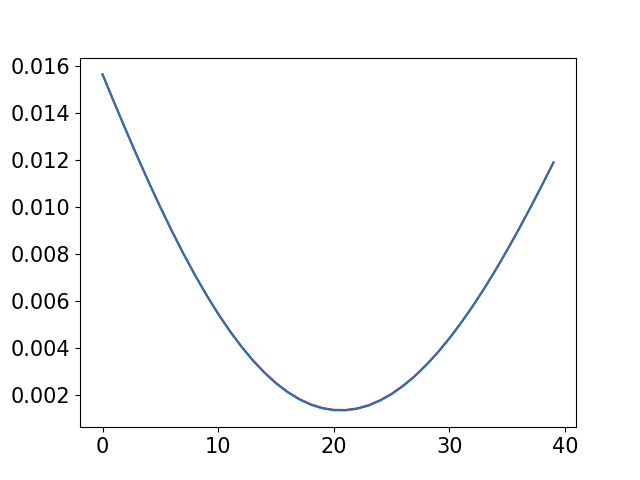

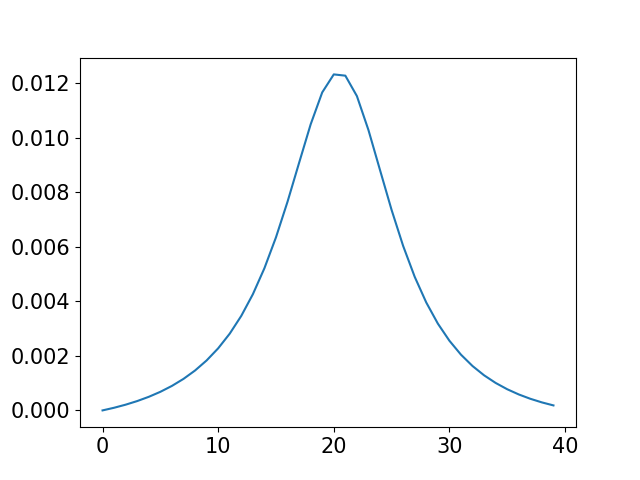

In [ ]:
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array([0,nx])


##Nice0Rand = np.random.random(Ntot0.shape)
x = np.arange(0,2*np.pi,2*np.pi/512)

Nice0Rand = np.sin(x)
NQLL0Rand = Nbar + Nstar * np.sin(2*np.pi*(Nice0Rand - Nbar))
Ntot0Rand = Nice0Rand + NQLL0Rand

initialDerivNew = f1dNew(0,Nice0Rand, float_params, sigmastep)
initialDerivOld = f1dOld(0, np.concatenate([NQLL0Rand,Ntot0Rand]), float_params, int_params, sigmastep)

##initialDerivNew - initialDerivOld[512:]

fig,ax = plt.subplots()
ax.plot(initialDerivNew[0:40],color='red')
ax.plot(initialDerivOld[512:552])

fig2,ax2 = plt.subplots()
ax2.plot((initialDerivNew[0:40] - initialDerivOld[512:552])/initialDerivOld[512:552])

Height of Ice 1224.0278260319028
1-D growth, corner 1257.1754950119023
1-D growth, center 1224.1356683953757
1-D Modeled growth rate, corner, um/s 1.8952394397164356
1-D Modeled growth rate, corner, ml/us 0.006317464799054785
1-D Modeled growth rate, center, um/s 1.8454306558724256
1-D Modeled alpha, corner 0.19340680052986614
1-D Modeled alpha, center 0.18878120179630672
Difference, % -2.391642238477093
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904


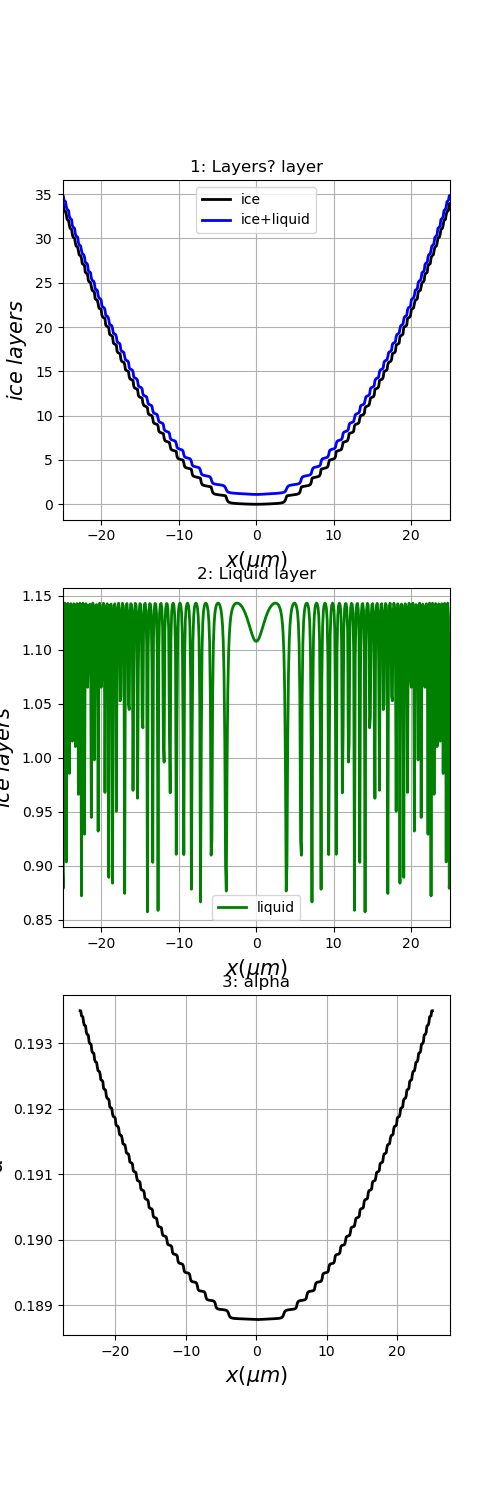

In [ ]:
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0


# NQLL = outOld.y[0:nx]
# Ntot = outOld.y[nx:]
# Nice = Ntot - NQLL
Ntot = out.y
NQLL = Nbar + Nstar * np.sin(2*np.pi*(Ntot - Nbar))
Nice = Ntot - NQLL

NtotFinal = Ntot[:,-1]
NQLLFinal = NQLL[:,-1]
NiceFinal = Nice[:,-1]


# Growth statistics
minpoint = min(NiceFinal)
# ncorner = 4 # why is ncorner 4 and not 0?

# # total height of ice
# print("Height of Ice", minpoint)

# # change in total ice depth at each grid point
delta_Ntot_entire = NtotFinal-Ntot[:,0]

# # growth at corner and in center
# print( "1-D growth, corner", delta_Ntot_entire[ncorner])
# print( "1-D growth, center", delta_Ntot_entire[nmid])

# # growth over time (growth rate)
growthrate_entire = delta_Ntot_entire/out.t[-1]*umpersec_over_mlyperus
# print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
# print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus) # why different units on this one?
# print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])

# # alpha is some other modified growth rate
alpha = growthrate_entire/nu_kin/sigmastep
# print( "1-D Modeled alpha, corner", alpha[ncorner])
# print( "1-D Modeled alpha, center", alpha[nmid])
# print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)

# # Comparisons with Libbrecht
# sigma0_L = 0.08
# A_L = .28
# alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
# print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
# print("Libbrecht's predicted alpha", alpha_L)

#########
# Plots #
#########

fig,axs = plt.subplots(3,1,figsize=(5,15))

# First plot: layers (rescaled to have minimum at zero, shifted so center of facet is at zero)
fignum +=1
axs[0].set_title(str(fignum)+': Layers? layer')
axs[0].plot(x-xmid, NiceFinal-minpoint, 'k', label='ice', lw=linewidth)
axs[0].plot(x-xmid, NtotFinal-minpoint, 'b', label='ice+liquid', lw=linewidth)
axs[0].set_xlabel(r'$x (\mu m$)',fontsize=fontsize)
axs[0].set_ylabel(r'$ice \ layers$',fontsize=fontsize)
axs[0].set_xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
axs[0].legend()
axs[0].grid('on')

# Second plot: liquid layer alone
fignum +=1
axs[1].set_title(str(fignum)+': Liquid layer')
axs[1].plot(x-xmid, NQLLFinal, 'g', label='liquid', lw=linewidth)
axs[1].set_xlabel(r'$x (\mu m$)',fontsize=fontsize)
axs[1].set_ylabel(r'$ice \ layers$',fontsize=fontsize)
axs[1].set_xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
axs[1].legend()
axs[1].grid('on')

# Third plot: alpha (a measure of growth rate at each point)
fignum +=1
axs[2].set_title(str(fignum)+': alpha')
axs[2].plot(x-xmid, alpha, 'k', lw=linewidth)
axs[2].set_xlabel(r'$x (\mu m$)',fontsize=fontsize)
axs[2].set_ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
axs[2].grid('on')


# Experiments with excluding calculations for Nqll til end

In [ ]:
#load a simulation

#load the ablation with initial noise run
#test_2d_asym = loadSim('f2d_simulation_asymmetric250_200_500layers_center_reduction0.1_D_2_RK45_sigmamax_-0.01noisyinit_True.pkl')

#load the growth with initial noise run
#test_2d_asym = loadSim('f2d_simulation_asymmetric250_200_500layers_center_reduction0.1_D_2_RK45_sigmamax_0.2noisyinit_True.pkl')


In [ ]:
#set up and run and plot a new simulation
test_2d_asym = Simulation(ds.f2d, (500,500), method='RK45')
test_2d_asym_test = Simulation(df.f2d, (500,500), method='RK45')

test_2d_asym_test.mem_check = True
test_2d_asym_test.discretization_halt = False
test_2d_asym_test.noisy_init = False
test_2d_asym_test.layermax = 1000
test_2d_asym_test.sigmastepmax = 0.20


#turn on memory handling logic
test_2d_asym.mem_check = True
#test_2d_asym.memory_threshold = 100E9 #100GB - default

test_2d_asym.discretization_halt = False

#try a noisy simulation
test_2d_asym.noisy_init = False

#test_2d_asym.float_params['DoverdeltaX2'] *= 2 
test_2d_asym.layermax = 1000
#test_2d_asym.sigmastepmax= -0.01#ablation
test_2d_asym.sigmastepmax= 0.20 #growth
#test_2d_asym.center_reduction = 0.25
#test_2d_asym.deltaT *= 10 #increase time step to decrease number of steps saved

#_plot = test_2d_asym.plot(tot=True,completion=1)
#anim = test_2d_asym.animate(ice=True,surface=True, ret=True, focus_on_growth=True)

1D model for comparison (uses same parameters as above 2d model), graphing if it also reaching steady state

In [ ]:
#create 1d sim and graph number of steps over time
ss_1d = Simulation(ds.f1d, (500,), method=test_2d_asym.method, rtol=test_2d_asym.rtol)
ss_1d_test = Simulation(df.f1d, (500,), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

ss_1d_test.float_params['DoverdeltaX2'] = test_2d_asym_test.float_params['DoverdeltaX2']
ss_1d_test.layermax = 50
ss_1d_test.sigmastepmax = test_2d_asym_test.sigmastepmax
ss_1d_test.sigma0 = test_2d_asym_test.sigma0
ss_1d_test.center_reduction = test_2d_asym_test.center_reduction
ss_1d_test.deltaT = test_2d_asym_test.deltaT
ss_1d_test.noisy_init = test_2d_asym_test.noisy_init

ss_1d.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
#ss_1d.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
ss_1d.layermax = 50 #make sure it reaches steady state
ss_1d.sigmastepmax = test_2d_asym.sigmastepmax 
ss_1d.sigma0 = test_2d_asym.sigma0
ss_1d.center_reduction = test_2d_asym.center_reduction
ss_1d.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
ss_1d.noisy_init = test_2d_asym.noisy_init


In [ ]:
#set the id 
# my_id=['nx_'+str(ss_1d.shape[0]),str(ss_1d.layermax)+'layers',
#                                 'center_reduction'+str(ss_1d.center_reduction),  'D_2', ss_1d.method, 'sigmamax_'+str(ss_1d.sigmastepmax) +'noisyinit_'+str(ss_1d.noisy_init)]
# my_filename = ''.join([i+'_' for i in my_id])

# my_id=['nx_'+str(ss_1d_test.shape[0]),str(ss_1d_test.layermax)+'layers',
#                                 'center_reduction'+str(ss_1d_test.center_reduction),  'D_2', ss_1d_test.method, 'sigmamax_'+str(ss_1d_test.sigmastepmax) +'noisyinit_'+str(ss_1d_test.noisy_init)]
# my_filename = ''.join([i+'_' for i in my_id])

In [ ]:
# plot number of steps over time
fignum = 0
plt.close(fignum)

Ntot = ss_1d.getNtot()
NtotTest = ss_1d_test.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])
maxes1 = np.array([np.max(n) for n in NtotTest[:]])
mins1 = np.array([np.min(n) for n in NtotTest[:]])

#print(maxes,mins)
plt.figure(fignum)
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(Ntot[:,0],maxes-mins,color='blue',label='original')
ax.plot(NtotTest[:,0],maxes1-mins1,color='red',linestyle='--',label='Testing')

ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
ax.legend()
plt.grid()
plt.show()

breaking because reached max number of layers grown


TypeError: too many arguments: expected 4, got 5

500 324
(324, 500) (324, 500) (324, 500)
500 324
(324, 500) (324, 500) (324, 500)


C:\Users\elsla\AppData\Local\Temp\ipykernel_38676\4106757936.py:36: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL')#, cmap='viridis_r')


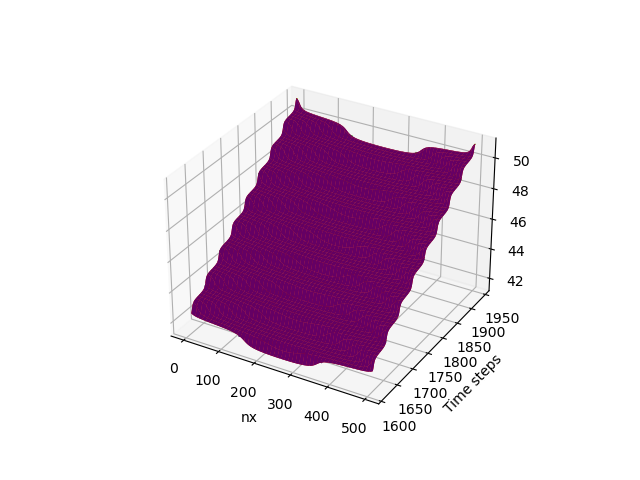

In [ ]:
plt.close('1d surface over time 3d surface')
plt.figure('1d surface over time 3d surface')
#plot surface over time as 3d surface
ax = plt.axes(projection='3d')

zss = ss_1d_test.getNtot()
start,stop = 0,zss.shape[0]
start,stop = stop*5//6, stop
zss = zss[start:stop]
tt,xx = [*zss.shape]
print(xx,tt)
xss,yss = np.meshgrid(np.linspace(0,xx,xx),np.linspace(start,stop,stop-start))
print(xss.shape,yss.shape,zss.shape)
levels = np.linspace(740,880,10)
ax.contour(X=xss,Y=yss,Z=zss)
ax.plot_surface(X=xss,Y=yss,Z=zss,color='purple')


zs = ss_1d.getNtot()
start,stop = 0, zs.shape[0]
#crop time selection
start,stop = stop*5//6, stop
zs = zs[start:stop]

t,x = [*zs.shape]
print(x,t)
xs,ys = np.meshgrid(np.linspace(0,x,x),np.linspace(start,stop,stop-start))

#print shapes of inputs
print(xs.shape,ys.shape,zs.shape)

#contour levels
levels = np.linspace(740,880,10)

#plot contours of the surface
ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL')#, cmap='viridis_r')

#plot the surface with reversed viridis
ax.plot_surface(X=xs, Y=ys, Z=zs,  label='ice+QLL',color='red')#, cmap='viridis_r')

ax.set_xlabel('nx')
ax.set_ylabel('Time steps')
#ax.set_xlabel(r'x ($\mu m$)')
#ax.set_ylabel('Layers of ice')
plt.show()

500 19866
(19866, 500) (19866, 500) (19866, 500)


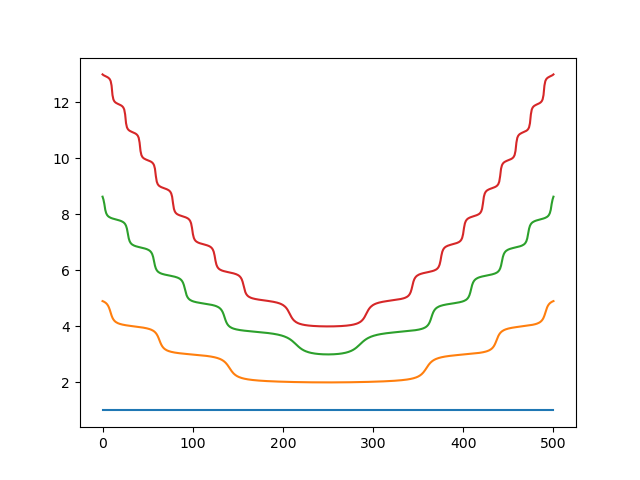

In [ ]:
#plot contours over time on one surface
ax = plt.axes(projection='3d')

zs = ss_1d.getNtot()
start,stop = 0, zs.shape[0]
#crop time selection
#start,stop = stop*5//6, stop
zs = zs[start:stop]

t,x = [*zs.shape]
print(x,t)
xs,ys = np.meshgrid(np.linspace(0,x,x),np.linspace(start,stop,stop-start))

#print shapes of inputs
print(xs.shape,ys.shape,zs.shape)

# #contour levels
# levels = np.linspace(740,880,10)

# #plot the surface with reversed viridis
# ax.contour(X=xs, Y=ys, Z=zs,  label='ice+QLL', cmap='viridis_r')

# ax.set_xlabel('nx')
# ax.set_ylabel('Time steps')
# #ax.set_xlabel(r'x ($\mu m$)')
# #ax.set_ylabel('Layers of ice')
# plt.show()

ix = 100
plt.figure()

ixlist = [0, 4_000, 8_000, 16_000]#np.linspace(0,7400, 100)
offset = 1
for ix in ixlist:
    tempzs = zs[ix,:] - min(zs[ix,:]) + offset
    offset += 1
    plt.plot(xs[ix,:], tempzs,label = 'x = '+str(ix))

#plt.legend()

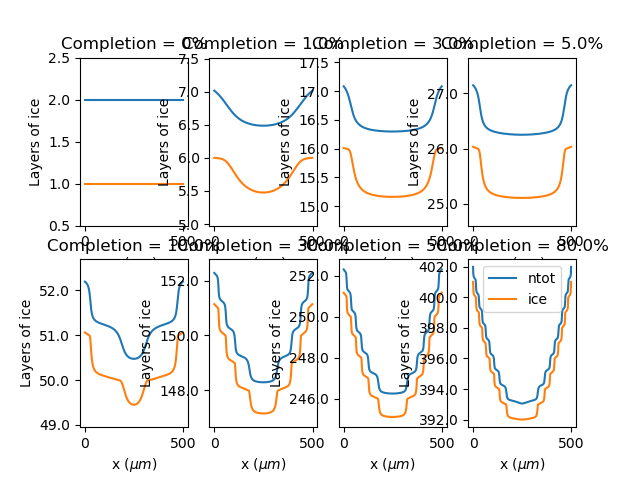

In [ ]:
#plot the surface over time on subplots

#run the simulation
ntot = ss_1d.getNtot()
nice = ss_1d.getNice()

#plot the surface over time on subplots
fig, axs = plt.subplots(2, 4)
for i, cmpltion in enumerate([0,0.01,0.03,0.05,0.1,0.3,0.5,0.8]):
#for i, cmpltion in enumerate([0.1,0.12,0.15, 0.18,0.2,0.23,0.26,0.3]):

    xs = ntot[int(cmpltion*ntot.shape[0]),:]
    ice = nice[int(cmpltion*nice.shape[0]),:]
    axs[i//4, i%4].set_xlabel(r'x ($\mu m$)')
    axs[i//4, i%4].set_ylabel('Layers of ice')
    axs[i//4, i%4].set_ylim(bottom=min(ice)-.5, top=max(xs)+.5)
    axs[i//4, i%4].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[i//4, i%4].set_title('Completion = '+str(cmpltion*100)+'%')
    axs[i//4, i%4].plot(xs, label='ntot')
    axs[i//4, i%4].plot(ice, label='ice')

plt.legend()
plt.show()

In [ ]:
# import csv

# # Get x, xs, ice at steady state (for reference 1D system)
# xs = ntot[int(ntot.shape[0])-1, :]
# ice = nice[int(nice.shape[0])-1, :]

# # Generate the range of x values from -250 to 250
# x = range(-250, 251)

# # Create a list of lists containing x, xs, and ice values
# data = [[xi, xsi, icei] for xi, xsi, icei in zip(x, xs, ice)]

# # Write the data to a CSV file
# with open('data/output.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['x', 'ntot', 'nice'])  # Write header row
#     writer.writerows(data)  # Write data rows


FileNotFoundError: [Errno 2] No such file or directory: 'data/output.csv'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


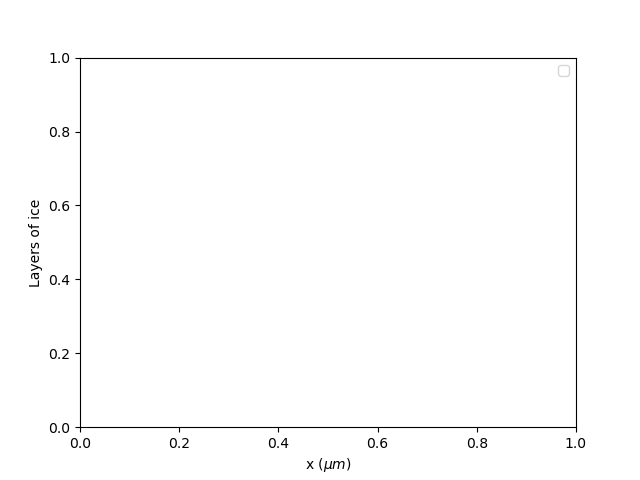

In [ ]:
ss_1d.animate()

In [ ]:
plt.close()


In [ ]:
#test_2d_asym.save(id=['asymmetric'+str(test_2d_asym.shape[0])+'_'+str(test_2d_asym.shape[1]),str(test_2d_asym.layermax)+'layers'])
#symm = Simulation(f2d,(500,500),rtol=1e-12)

In [ ]:
# #countour plot of sigmastep 2d
# plt.figure()
# ax = plt.axes(projection='3d')
# plt.xlabel(r'x ($\mu m$)')
# plt.ylabel(r'y ($\mu m$)')
# #ax.set_zlabel('Layers of ice')
# #levels = np.arange(19,21,0.1)
# ax.contourf(xgrid,ygrid, sigma*100, extent=(0, 2, 0, 2), cmap='YlGnBu_r', vmin=0, vmax=200, zorder=1)#, levels=levels)

In [ ]:
# #countour plot of sigmastep 2d
# print(xs.shape,ys.shape,sigma.shape)
# fig,ax = plt.subplots()
# CS = ax.contourf(xs.T,ys.T,sigma*100)
# ax.set_xlabel(r'$x (\mu m)$', fontsize=20)
# ax.set_ylabel(r'$y (\mu m)$', fontsize=20)
# plt.grid(True)
# plt.gca().set_aspect('equal')
# fig.colorbar(CS)
# plt.title('%supersaturation (getsigmastep_2d)')

0D model for comparison (uses same parameters as above 2d model)

In [ ]:
#create 1d sim and graph number of steps over time
#ss_1d = Simulation(f1d, (test_2d_asym.shape[0],), method=test_2d_asym.method, rtol=test_2d_asym.rtol)
ss_0d = Simulation(ds.f0d, (1,), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

# NOTE: 0d ablation sim halting is not implemented...
ss_0d.uselayers = False
ss_0d.countermax = 1750 #about 10 layers

ss_0d.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
#ss_1d.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
ss_0d.layermax = 10 
#ss_0d.sigmastepmax = test_2d_asym.sigmastepmax 
ss_0d.sigmastepmax = -0.01
ss_0d.sigma0 = test_2d_asym.sigma0
ss_0d.center_reduction = test_2d_asym.center_reduction
ss_0d.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
ss_0d.noisy_init = test_2d_asym.noisy_init

In [ ]:
print(ss_0d.sigmastepmax)
print(ss_0d.sigma0)

-0.01
0.19


In [ ]:
#run the sim, get results
#nice_0d = ss_0d.getNice() #NOTE: current version of getNice() returns a 2d array
ntot_0d = ss_0d.getNtot()
fliq_0d = ss_0d.getFliq()
nice_0d = ntot_0d - fliq_0d

breaking because reached max number of iterations


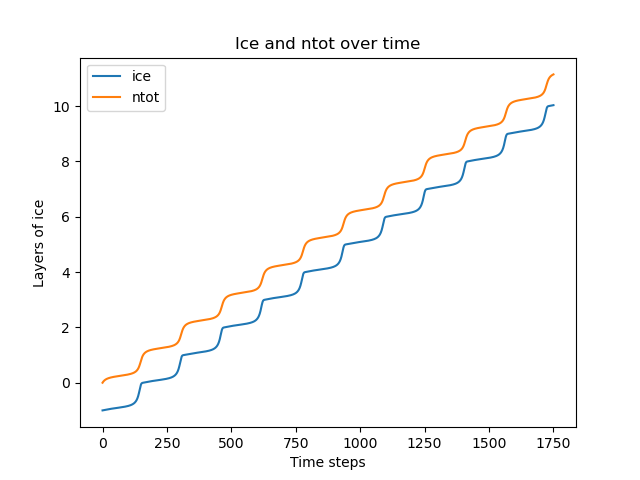

In [ ]:
#plot ice and ntot over time
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Time steps')
ax.set_ylabel('Layers of ice')
ax.set_title('Ice and ntot over time')
ax.plot(nice_0d, label='ice')
ax.plot(ntot_0d, label='ntot')
plt.legend()
plt.show()

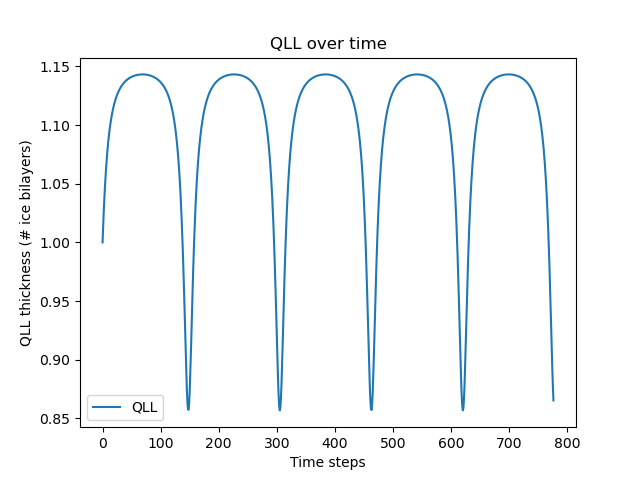

In [ ]:
#plot QLL over time (illustrates microsurfaces), diffusive slowdown
fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Time steps')
ax.set_ylabel('QLL thickness (# ice bilayers)')
ax.set_title('QLL over time')
ax.plot(fliq_0d[:777], label='QLL')
plt.legend()
plt.show()


2D Growth simulation

In [ ]:
# #create the 2d sim
# test_f2d_sim = Simulation(f2d, (250,250), rtol=1e-12)
# test_f2d_sim.layermax = 50#0
# #test_f2d_sim.run()
# #test_f2d_sim.save(_id=['test','50layer'])

In [ ]:
# #animate the 2d sim
# test_f2d_sim.animate(crossSection=True)

In [ ]:
# #print variables in 1d simulation for comparison to literature
# for k,v in test_f2d_sim._extra_vars.items():
#     print(k,v)
# print('center reduction %: ', test_f2d_sim.center_reduction)

In [ ]:
# #print number of steps over time
# Ntot = test_f2d_sim.getNtot()

# maxes = np.array([np.max(n) for n in Ntot[:]])
# mins = np.array([np.min(n) for n in Ntot[:]])

# #print(maxes,mins)
# plt.figure()
# ax = plt.subplot(111)

# #ax.plot(test_f2d_sim.results()['t'],maxes-mins)
# ax.plot(Ntot[:,0,0],maxes-mins)
# #ax.plot(test_f2d_sim.results()['t'],test_f2d_sim.results()['t'])
# plt.grid()

In [ ]:
# #animate test_f2d_sim

# test_f2d_sim.animate(ice=True)

In [ ]:
#test_f2d_sim = loadSim('f2d_simulation_test_50layer.pkl') 

In [ ]:
# #graph results normalized to minimum of ice surface
# Fliq_ss, Ntot_steadystate = test_f2d_sim.normalize_results_to_min()
# nice_ss = Ntot_steadystate-Fliq_ss
# print(np.shape(Ntot_steadystate))
# xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection = '3d')
# #ax.plot_surface(test_f2d_sim._results['t'], Ntot_steadystate[:,])
# ax.set_xlabel(r'$x (\mu m$)')#,fontsize=fontsize)
# ax.set_ylabel(r'$y (\mu m$)')#,fontsize=fontsize)
# ax.set_zlabel(r'$ice \ layers$')#,fontsize=fontsize)
# #limits
# #ax.set_zlim3d(-self.layermax, self.layermax)
# #ax.set_ylim(0, max(self.y))
# #ax.set_xlim(0, max(self.x))
# def update_fig(num):
#     ax.clear() # remove last iteration of plot 
#     plot_func = ax.plot_surface
#     # if crossSection:
#     #     xmid = round(np.shape(Nice)[0]/2)
#     #     if ice:
#     #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=nice_ss[num][xmid:][:],cmap ='viridis')# cmap='viridis')#, vmin=0, vmax=200) #plot half of the surface of the ice
#     #     if tot:
#     #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=Ntot_steadystate[num][xmid:][:], cmap='cividis')#, vmin=0, vmax=200) #plot half the surface of the QLL
#     # else:
#     #     if ice:
#     plot_func(X=xs, Y=ys, Z=nice_ss[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice 
#         # if tot:
#     # plot_func(X=xs, Y=ys, Z=Ntot_steadystate[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
#     pass


# num_steps = len(test_f2d_sim._results['t'])
# import matplotlib.animation as animation
# ani = animation.FuncAnimation(fig , update_fig, num_steps, interval=50, blit=False, cache_frame_data=False, repeat = True)
# plt.show()

In [ ]:
# #graph difference in steps over time: should converge to zero if steady state is reached
# Fliq_ss, Ntot_steadystate = test_f2d_sim.steady_state_calc()
# nice_ss = Ntot_steadystate-Fliq_ss
# print(np.shape(Ntot_steadystate))
# xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection = '3d')
# #ax.plot_surface(test_f2d_sim._results['t'], Ntot_steadystate[:,])
# ax.set_xlabel(r'$x (\mu m$)')#,fontsize=fontsize)
# ax.set_ylabel(r'$y (\mu m$)')#,fontsize=fontsize)
# ax.set_zlabel(r'$ice \ layers$')#,fontsize=fontsize)
# #limits
# #ax.set_zlim3d(-self.layermax, self.layermax)
# #ax.set_ylim(0, max(self.y))
# #ax.set_xlim(0, max(self.x))
# def update_fig(num):
#     ax.clear() # remove last iteration of plot 
#     plot_func = ax.plot_surface
#     # if crossSection:
#     #     xmid = round(np.shape(Nice)[0]/2)
#     #     if ice:
#     #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=nice_ss[num][xmid:][:],cmap ='viridis')# cmap='viridis')#, vmin=0, vmax=200) #plot half of the surface of the ice
#     #     if tot:
#     #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=Ntot_steadystate[num][xmid:][:], cmap='cividis')#, vmin=0, vmax=200) #plot half the surface of the QLL
#     # else:
#     #     if ice:
#     plot_func(X=xs, Y=ys, Z=nice_ss[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice 
#         # if tot:
#     # plot_func(X=xs, Y=ys, Z=Ntot_steadystate[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
#     pass


# num_steps = len(test_f2d_sim._results['t'])
# import matplotlib.animation as animation
# ani = animation.FuncAnimation(fig , update_fig, num_steps, interval=50, blit=False, cache_frame_data=False, repeat = True)
# plt.show()

In [ ]:
# test_2d_sim = Simulation(f2d, (500,500), rtol=1e-12)
# test_2d_sim.layermax = 2
# #test_2d_sim = loadSim('f2d_simulation_august13.pkl')
# _plot = test_2d_sim.plot()

1d simulation 

In [ ]:
test_2d_sim.save(id=['august13'])

NameError: name 'test_2d_sim' is not defined

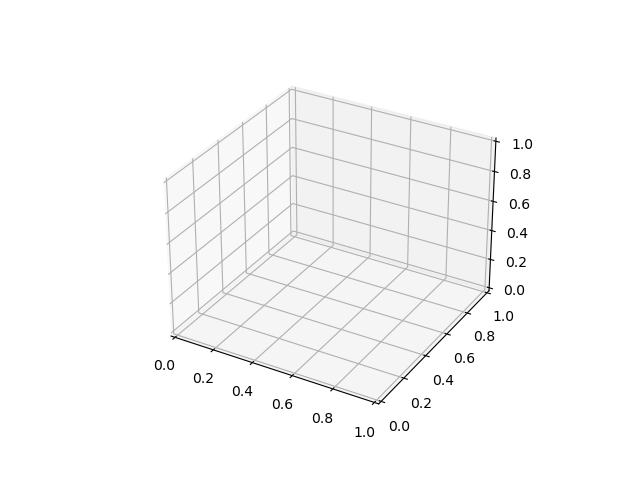

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
num_steps = len(test_2d_sim.results()['t'])
xs,ys = np.meshgrid(test_2d_sim.x, test_2d_sim.y)
ax.plot_surface(X=xs, Y=ys, Z=test_2d_sim.getNtot()[num_steps-1], cmap='viridis')

In [ ]:
test_1d = SimulationNew(df.f1d, shape=(500,), rtol=1e-12)
test_1d.layermax = 500
test_1d.results()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


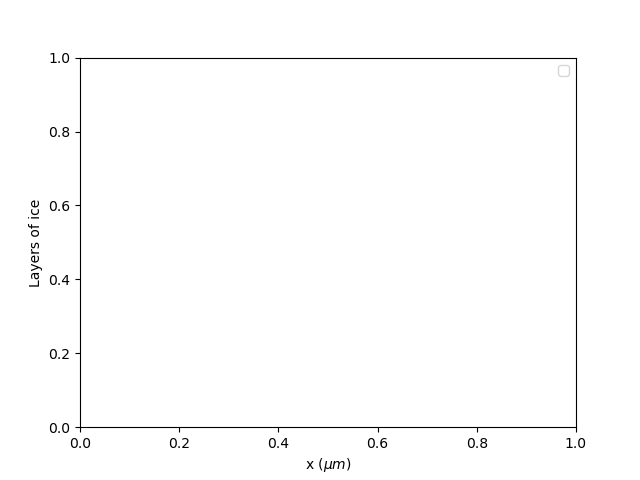

In [ ]:
test_1d.animate(ice=True, tot=True)
#test_1d.plot()

2d Idea: increase sigmastepmax to see if faceted growth occur, removing the concave "bowl" forming at the center of initially tested 2d systems (test_f2d_sim)

In [ ]:
# sigma_test = Simulation(f2d, (500,500),rtol = 1e-12)
# sigma_test.layermax = 100
# sigma_test.sigmastepmax = 0.25
# sigma_test.results()

In [ ]:
#sigma_id = ['sigmastepmax_'+str(round(100*sigma_test.sigmastepmax)), str(sigma_test.layermax)+'layers']
#sigma_test.save(id=sigma_id)

#test increased layers with increased sigmastep

#sigma_test = loadSim('f2d_simulation_sigmastepmax_025.pkl') # 20 layers?
#sigma_test = loadSim('f2d_simulation_sigmastepmax_025_50layers.pkl')
sigma_test = loadSim('f2d_simulation_sigmastepmax_25_100layers.pkl')

In [ ]:
sigma_test.animate()

2d Ablation testing

In [ ]:
f2d_ablate = Simulation(f2d, (500,500), rtol=1e-12)
f2d_ablate.sigmastepmax = -0.1
f2d_ablate.layermax = 50
f2d_ablate.animate()

1d growth testing. Works, however does not currently match the literature graph despite using the same parameters.

In [ ]:
f1d_sim = Simulation(f1d, (500,), rtol=1e-12)

In [ ]:
#change parameters to match Gladich et al paper's graph and run simulation
f1d_sim.layermax = 500#10000
#f1d_sim.center_reduction = 0.25 #is default now

In [ ]:
f1d_sim.run()

In [ ]:
fig = f1d_sim.plot(completion=0.99, ice=True, tot=True)

In [ ]:
#print variables in 1d simulation for comparison to literature
for k,v in f1d_sim._extra_vars.items():
    print(k,v)
print('center reduction %: ', f1d_sim.center_reduction)

In [ ]:
#functions tested so far
#test_f2d_sim.countermax_0D
#test_f2d_sim.countermax_1D
#test_f2d_sim.countermax_2D
#test_f2d_sim.atol
#test_f2d_sim.rtol
#test_f2d_sim.deltaT
#test_f2d_sim.float_params
#test_f2d_sim.animate()
#test_f2d_sim.run()
#test_f2d_sim.steady_state_calc()
#test_f2d_sim.plot()
#test_f2d_sim.save()
#test_f2d_sim.load() #WORKS to load simulation from file if simulation object exists already -- for loading straght froom file use loadSim()
#loadSim() #works



In [ ]:
num_steps = len(test_f2d_sim.results()['t'])
#shape of results is (num_steps, 2, nx, ny)
Fliq, Ntot = [],[]
for step in range(num_steps):
    next_Fliq, next_Ntot = test_f2d_sim._results['y'][step]
    Fliq.append(next_Fliq)
    Ntot.append(next_Ntot)    
Fliq,Ntot = np.array(Fliq), np.array(Ntot)
Nice = Ntot - Fliq
#shape of fliq, ntot and nice should be (num_steps, nx, ny)

#access coordinate arrays for plotting
xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

In [ ]:
print(num_steps)
print(test_f2d_sim.steepness(0,slice(0,test_f2d_sim.shape[0]//2)))

In [ ]:
print(test_f2d_sim.get_step_density(0,slice(0,test_f2d_sim.shape[0]//2)))  